# 


![](https://github.com/rajeevratan84/ModernComputerVision/raw/main/logo_MCV_W.png)

# **Generate Anime Characters**

---


In this lesson will learn to use StyleGAN to generate Anime Characters!

### **Downgrade to Tensorflow 1.15**

In [1]:
%tensorflow_version 1.x
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__) )

TensorFlow 1.x selected.
Tensorflow version: 1.15.2


## **Clone StyleGan2**

In [2]:
!git clone https://github.com/NVlabs/stylegan2.git
%cd /content/stylegan2

Cloning into 'stylegan2'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 138 (delta 4), reused 10 (delta 4), pack-reused 127
Receiving objects: 100% (138/138), 599.47 KiB | 871.00 KiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/stylegan2


In [5]:
# Old code that is on the video, however this no longer works and is replaced by the code below.

# import pretrained_networks
# from google_drive_downloader import GoogleDriveDownloader as gdd

# url = 'https://drive.google.com/open?id=1utL6RpjEiLvJ-k994kmjCuDbc3FybP-m'

# model_id = url.replace('https://drive.google.com/open?id=', '')

# network_pkl = '/content/models/model_%s.pkl' % model_id
# gdd.download_file_from_google_drive(file_id=model_id,dest_path=network_pkl)

# #_G, _D, Gs = pretrained_networks.load_networks(network_pkl)

'/content/models/model_1utL6RpjEiLvJ-k994kmjCuDbc3FybP-m.pkl'

In [8]:
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/network-snapshot-018528.pkl
%mv network-snapshot-018528.pkl ../models/
_G, _D, Gs = pretrained_networks.load_networks(f'/content/models/network-snapshot-018528.pkl')

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [ ]:
import numpy as np

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

In [ ]:
import dnnlib
import dnnlib.tflib as tflib
import PIL.Image
from tqdm import tqdm

noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in tqdm(enumerate(zs)):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

In [ ]:
# generate some random seeds
seeds = np.random.randint(10000000, size=9)
print(seeds)

zs = generate_zs_from_seeds(seeds)
imgs = generate_images(zs, .7)

[ 783602 6506592 5842888 7319191 3194881 8133786 2265318 1017335 4475296]


9it [00:00, 15.94it/s]


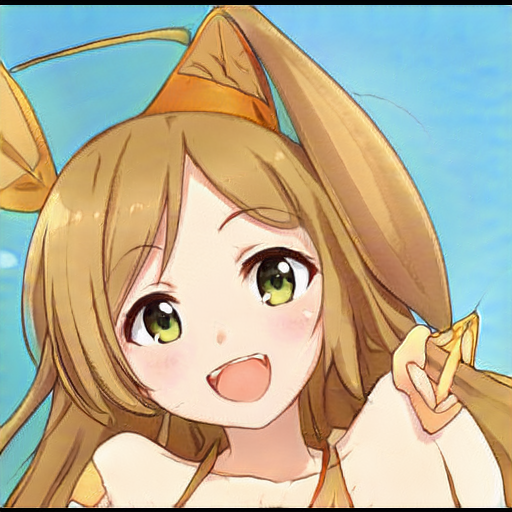

In [ ]:
imgs[0]

In [ ]:
from math import ceil

def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

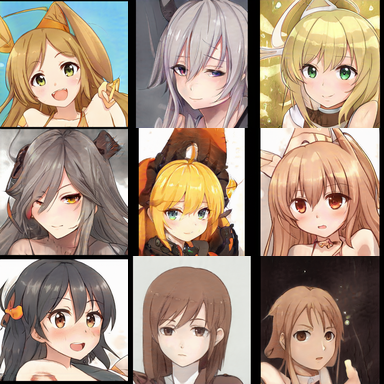

In [ ]:
createImageGrid(imgs, rows=3)

In [ ]:
def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)

7it [00:01,  4.21it/s]


7it [00:00, 16.43it/s]


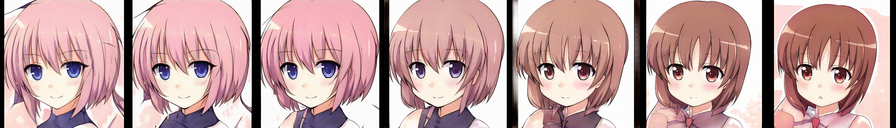

In [ ]:
seeds = np.random.randint(10000000, size=2)
zs = generate_zs_from_seeds(seeds)
imgs = generate_images(interpolate(zs, 7), 0.5)
createImageGrid(imgs, rows=1)